## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [2]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt


## Read the pre-processed data
- runall sample 1 case
- LHS205 case
- 196 samples in total

In [3]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

load_dfall = pd.read_csv(os.path.join(folder_path, 'DGSA_exp1.csv'))
load_rst_npy = np.load(os.path.join(folder_path, 'DGSA_exp1.npy'))
dfexpX = load_dfall[load_dfall.columns[4:-1]]
num_sample = load_rst_npy.shape[0]

## Read latent vectors from autoencoder

In [21]:
# dfAE = pd.read_csv(os.path.join(folder_path, 'AE_models', 'aemodel_leakyReLU_128epoch_latent_vector.csv'))
# latent_vector = dfAE.values

latent_vector = np.load(os.path.join(folder_path, 'AE_models', 'aemodel_leakyReLU_128epoch_latent_vector.npy'))

## For 3D case DGSA work

- autoencoder latent vector

In [32]:

parameters = dfexpX.values
responses = latent_vector

parameter_names = dfexpX.columns.to_list()


In [36]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [140]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-6)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [141]:
from pyDGSA.dgsa import dgsa

mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   sensitivity  confidence
E_shale, psi          0.986314    0.484493
E_sand, psi           2.039741    0.994493
v_shale               0.455690    0.203104
v_sand                0.741856    0.301270
kvkh                  0.379812    0.163274
inj_rate, ft3/day     1.874721    0.795634
inj_hrzn, year        1.103723    0.515564


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [142]:
# cluster_names = ['Low cluster', 'Medium cluster', 'High cluster']
cluster_names = [f'Cluster{i+1}' for i in range(n_clusters)]


cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

                   Cluster1  Cluster2  Cluster3
E_shale, psi       1.704210  0.352478  1.697863
E_sand, psi        2.544477  1.661703  3.667367
v_shale            0.286981  0.748878  0.719680
v_sand             1.408398  0.224401  1.230393
kvkh               0.639926  0.336933  0.490915
inj_rate, ft3/day  3.615039  0.676315  3.101065
inj_hrzn, year     1.490572  0.790999  2.000355


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [143]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
inj_rate, ft3/day | E_sand, psi       1.213308
E_sand, psi | inj_rate, ft3/day        1.18328
inj_hrzn, year | kvkh                 0.860217
inj_rate, ft3/day | inj_hrzn, year    0.832549
E_sand, psi | E_shale, psi            0.798894
kvkh | inj_hrzn, year                  0.79282
inj_hrzn, year | inj_rate, ft3/day    0.750922
v_sand | E_shale, psi                 0.705878
E_shale, psi | E_sand, psi            0.696177
inj_rate, ft3/day | kvkh              0.690922
E_shale, psi | inj_rate, ft3/day      0.687708
inj_hrzn, year | v_sand               0.686836
inj_hrzn, year | E_sand, psi          0.666533
kvkh | E_sand, psi                    0.659907
inj_rate, ft3/day | E_shale, psi       0.65512
kvkh | v_shale                        0.651106
v_sand | inj_hrzn, year               0.644343
inj_rate, ft3/day | v_sand            0.640204
inj_hrzn, year | v_shale              0.634973
E_sand, psi | kvkh                    0.627188
E_sand, psi |

Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [144]:
sens = dgsa_interactions(parameters, labels, 
                        #  cond_parameters=['depth','deviation','length', 'direction'], 
                         cond_parameters=parameter_names,
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
E_sand, psi | inj_rate, ft3/day       0.964939
inj_rate, ft3/day | E_sand, psi       0.956095
E_sand, psi | E_shale, psi            0.857436
E_shale, psi | E_sand, psi             0.79795
inj_hrzn, year | kvkh                 0.780923
inj_hrzn, year | inj_rate, ft3/day    0.761455
E_shale, psi | inj_rate, ft3/day      0.750799
inj_hrzn, year | v_sand               0.747986
kvkh | inj_hrzn, year                 0.740168
E_shale, psi | v_sand                 0.711891
E_sand, psi | inj_hrzn, year          0.708775
E_sand, psi | v_shale                 0.706729
inj_hrzn, year | E_sand, psi          0.702748
E_sand, psi | v_sand                  0.685624
kvkh | v_shale                        0.684784
inj_rate, ft3/day | inj_hrzn, year    0.667872
v_sand | inj_hrzn, year               0.652868
E_shale, psi | v_shale                0.648616
inj_rate, ft3/day | v_shale           0.646777
inj_rate, ft3/day | E_shale, psi      0.639447
kvkh | inj_ra

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [145]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1  Cluster2  Cluster3
E_sand, psi | E_shale, psi          0.492764  0.547634   1.35198
v_shale | E_shale, psi              0.580094  0.349341  0.694204
v_sand | E_shale, psi               0.406828  0.980481  0.743028
kvkh | E_shale, psi                 0.647677  0.460497  0.680942
inj_rate, ft3/day | E_shale, psi    0.633308  0.569704  0.758984
inj_hrzn, year | E_shale, psi       0.636114  0.333795  0.629185
E_shale, psi | E_sand, psi          0.593602  0.532179  0.959773
v_shale | E_sand, psi               0.216625  0.580191  0.503338
v_sand | E_sand, psi                0.348377  0.476017  0.667922
kvkh | E_sand, psi                   0.57789  0.717087  0.674606
inj_rate, ft3/day | E_sand, psi     0.683877  1.787631  1.164406
inj_hrzn, year | E_sand, psi        0.681511  0.672377  0.636655
E_shale, psi | v_shale               0.58386  0.444696  0.791916
E_sand, psi | v_shale               0.326279  0.810244  0.722043
v_sand | v_shale         

To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [146]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1                      Cluster2  \
                                       Bin 0     Bin 1     Bin 2     Bin 0   
E_sand, psi | E_shale, psi            0.2835  0.731852  0.449349  0.583902   
v_shale | E_shale, psi              0.476861  0.929243   0.33512  0.272766   
v_sand | E_shale, psi               0.217248  0.515988  0.488128   0.98764   
kvkh | E_shale, psi                 0.391967  0.729854  0.824551  0.392585   
inj_rate, ft3/day | E_shale, psi    0.529421  0.768902   0.59911  0.670292   
inj_hrzn, year | E_shale, psi       0.280966  0.608702  1.020868  0.194624   
E_shale, psi | E_sand, psi          0.529564  0.627359       NaN  0.665283   
v_shale | E_sand, psi               0.184539  0.257173       NaN  0.507066   
v_sand | E_sand, psi                0.307029  0.390893       NaN  0.307248   
kvkh | E_sand, psi                  0.504156  0.669075       NaN  0.678734   
inj_rate, ft3/day | E_sand, psi     0.667274  0.659499       NaN

## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

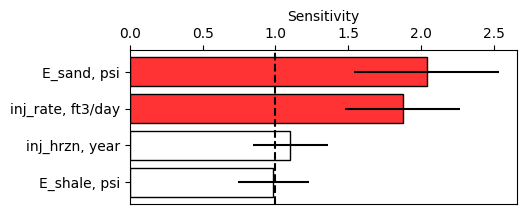

In [147]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

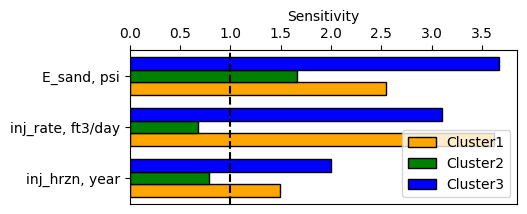

In [148]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'blue', 'red', 'black']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=3, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

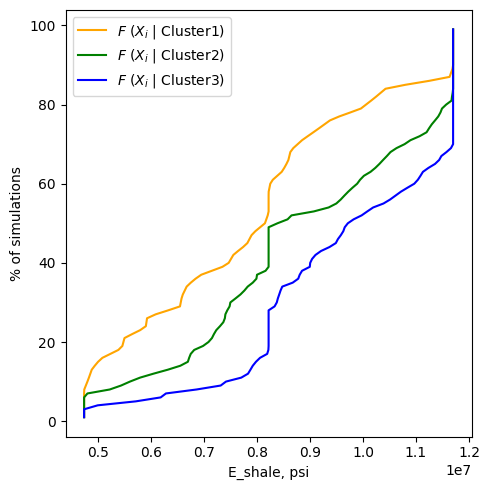

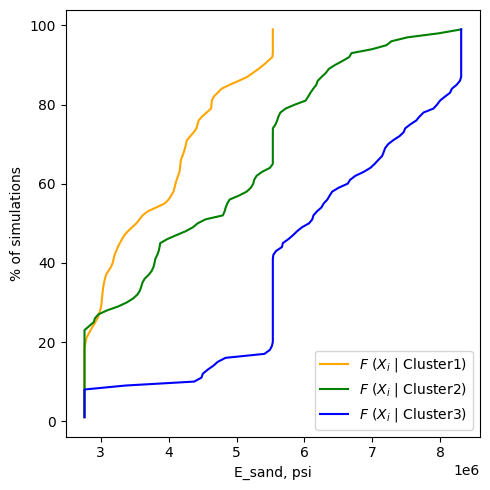

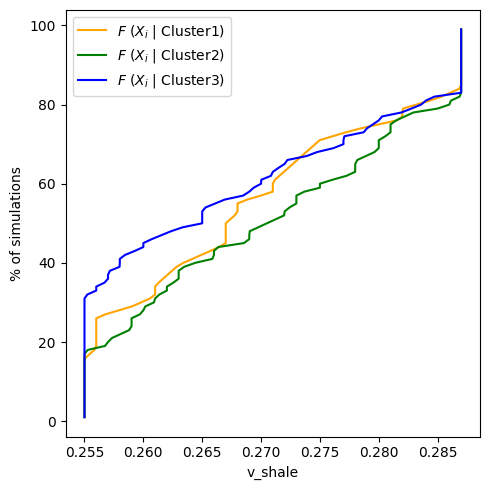

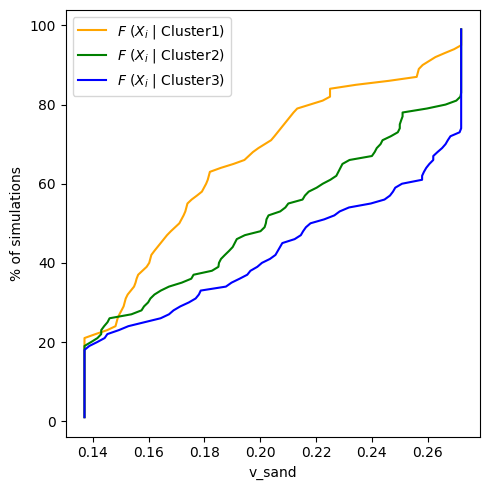

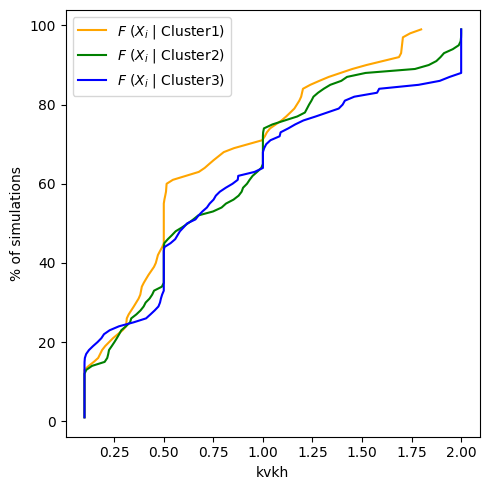

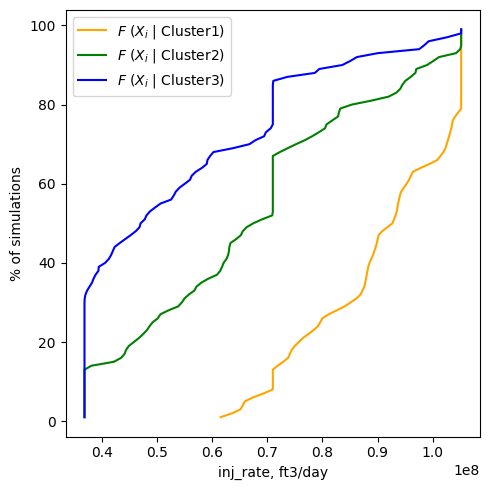

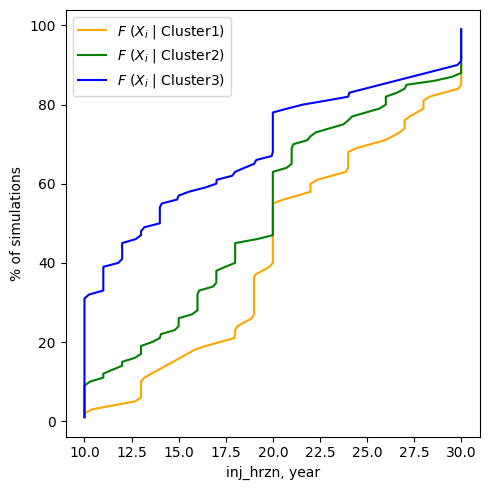

In [149]:
from pyDGSA.plot import plot_cdf

for item in parameter_names:
    fig, ax = plot_cdf(parameters, labels, item, parameter_names=parameter_names, 
                    cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

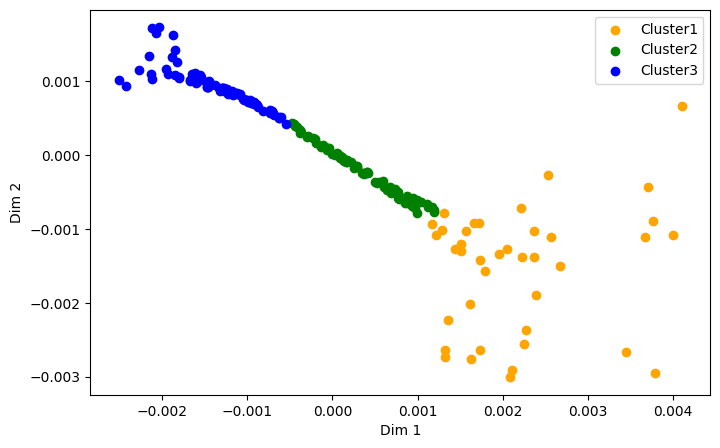

In [150]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

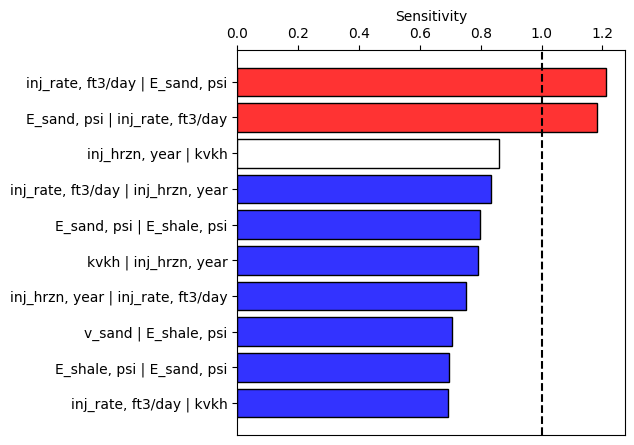

In [151]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

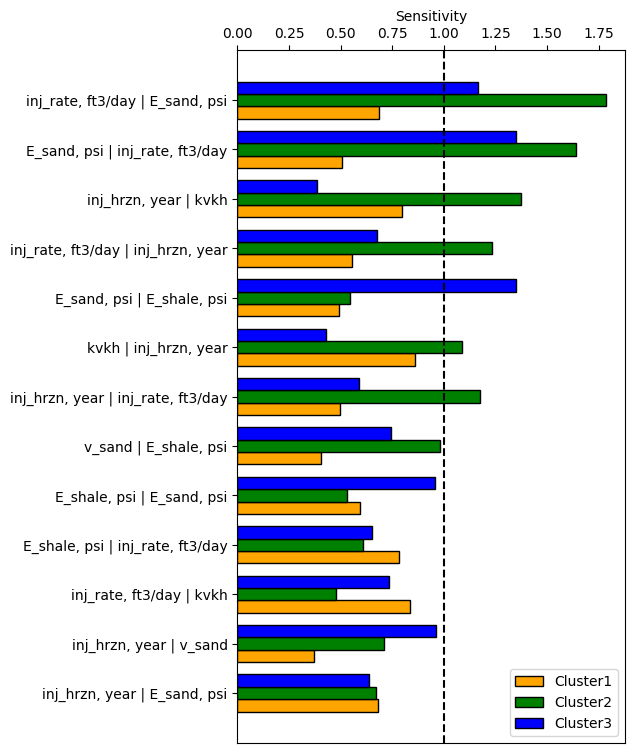

In [152]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

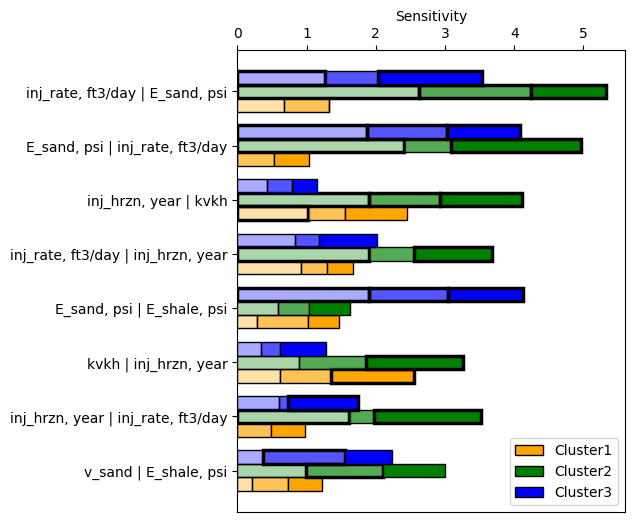

In [153]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)